In [3]:
import pandas as pd
import statsmodels.api as sm
import warnings 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from pandas_plink import read_grm
from pandas_plink import get_data_folder
import math

warnings.filterwarnings("ignore")

# louvain clusters

In [16]:
df = pd.read_csv("../clusters_ibd/louvain/fst_merged/louvain_original_001.csv")

In [19]:
df = df[df["sid"].str.isnumeric()]

In [32]:
df[df["merged_cluster"].isin(["cluster2"])][["sid", "sid"]].to_csv("european_irish.txt", sep="\t", index=False)

# phenotypes

In [47]:
bmi = pd.read_csv("../pheno/bmi.csv")

In [60]:
bmi = bmi[(bmi["lbs"] < 300) & (bmi["lbs"] > 80) ]
bmi = bmi[(bmi["inches"] < (7*12)) & (bmi["inches"] > (3*12)) ]

In [67]:
mean = bmi["bmi"].mean()
std = bmi["bmi"].std()

bmi = bmi[(bmi["bmi"] < (mean+(3*std))) &  (bmi["bmi"] > (mean-(3*std)))].sort_values(by="bmi")

In [69]:
questionnaire = pd.read_csv("../pheno/Questionnaire.txt", sep="|")

In [70]:
id_map_file = pd.read_csv("../../data/biome/pheno/ID_Masked_Mrn_Mapping.csv")
id_map_file["MASKED_MRN"] = id_map_file["MASKED_MRN"].astype(str)
questionnaire = questionnaire.merge(id_map_file, left_on="subject_id", right_on="SUBJECT_ID", how="left")

### phenotype with covariates 

In [71]:
questionnaire["age"] = 2024 - questionnaire["YEAR_OF_BIRTH"]
questionnaire["sex"] = questionnaire["GENDER"].replace({"Male":0, "Female":1, "Unknown":np.nan})

In [72]:
questionnaire = questionnaire.merge(bmi, on="subject_id")

In [100]:
pheno = questionnaire[["MASKED_MRN", "age", "sex", "bmi"]]

In [101]:
pheno = pheno.dropna()
pheno = pheno[pheno["age"] >= 18]

### adjusted phenotype

In [102]:
X = pheno[["age", "sex"]]
X = sm.add_constant(X)  
y = pheno["bmi"]

model = sm.OLS(y, X).fit()
adjusted_bmi = model.resid

pheno["adjusted_bmi"] = adjusted_bmi

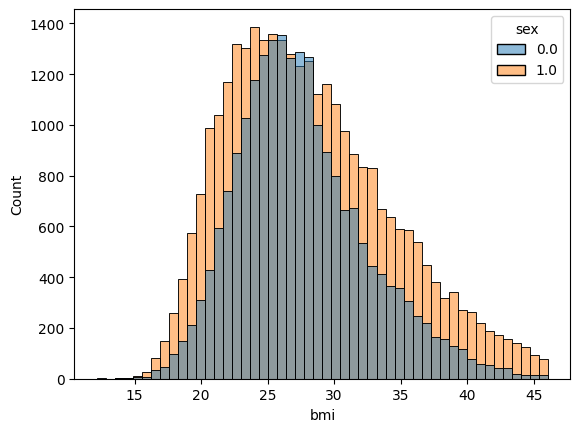

In [103]:
sns.histplot(x="bmi", hue="sex", data=pheno, bins=50)
plt.show()

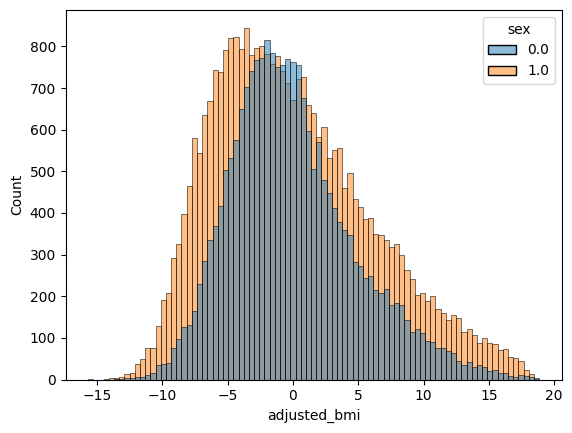

In [104]:
sns.histplot(x="adjusted_bmi", hue="sex", data=pheno)
plt.show()

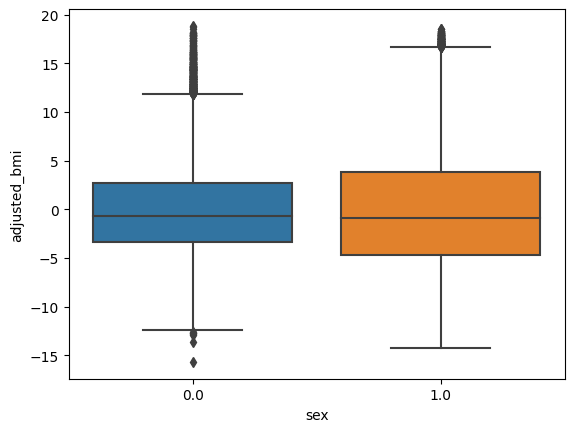

In [105]:
sns.boxplot(x="sex", y="adjusted_bmi", data=pheno)
plt.show()

In [85]:
bmi_adj = pheno[["MASKED_MRN", "MASKED_MRN", "adjusted_bmi"]]
bmi_adj.columns = ["FID", "IID", "bmi"]

In [107]:
bmi_adj.to_csv("pheno/bmi.txt", sep="\t", index=False)

# grm 

In [33]:
grm = read_grm("grm/european_irish_sample.grm.bin", "grm/european_irish_sample.grm.id")

In [34]:
grm_mat = grm[0].values

In [45]:
ids = pd.DataFrame(grm[0]["sample_0"].values)

# grm bins

In [47]:
bmi = pd.read_csv("pheno/bmi.txt", sep="\t")
bmi["IID"] = bmi["IID"].astype(str)
ids[0] = ids[0].astype(str)
bmi = ids.merge(bmi, left_on=0, right_on="IID", how="left")

In [59]:
bmi[["IID", "bmi"]].replace({np.nan:0}).to_csv("bmi_sample.txt", sep="\t", index=False, header=None)

,IID,bmi
0,146329,-7.685458
1,532274,11.288778
2,668015,1.506083
3,671611,-4.686767
4,681947,-9.466256
...,...,...
100,40008953,5.827861
101,44261932,-5.287772
102,45514640,-3.411401
103,46298375,-3.990659


In [50]:
def bin_and_calculate_covariance(genetic_relatedness_matrix, phenotype_values, num_bins=10):

    triu_indices = np.triu_indices(genetic_relatedness_matrix.shape[0], k=1)
    flat_relatedness = genetic_relatedness_matrix[triu_indices]
    
    bin_edges = np.linspace(flat_relatedness.min(), flat_relatedness.max(), num_bins + 1)
    print(bin_edges)
    results = {"bin_start": [], "bin_end": [], "count": [], "avg_covariance": []}
    
    for i in range(num_bins):
        bin_start, bin_end = bin_edges[i], bin_edges[i+1]
        
        pairs_in_bin = np.where((flat_relatedness >= bin_start) & (flat_relatedness < bin_end))[0]
        
        if len(pairs_in_bin) > 0:

            row_indices, col_indices = triu_indices[0][pairs_in_bin], triu_indices[1][pairs_in_bin]

            covariances = []
            for row, col in zip(row_indices, col_indices):
                pair1_pheno = phenotype_values.loc[row]
                pair2_pheno = phenotype_values.loc[col]
                
                if not (math.isnan(pair1_pheno) or math.isnan(pair2_pheno)):
                    cov = np.cov(pair1_pheno, pair2_pheno)[0, 1]
                    print(pair1_pheno, pair2_pheno)
                    print(cov)
                    covariances.append(cov)
            
            results["bin_start"].append(bin_start)
            results["bin_end"].append(bin_end)
            results["count"].append(len(pairs_in_bin))
            results["avg_covariance"].append(np.mean(covariances))
    
    return pd.DataFrame(results)


In [51]:
avg_cov = bin_and_calculate_covariance(grm_mat, bmi["bmi"])

[-0.02939032 -0.0128835   0.00362332  0.02013015  0.03663697  0.0531438
  0.06965062  0.08615745  0.10266427  0.11917109  0.13567792]
-7.685457823982301 1.506082664238761
nan
-7.685457823982301 -7.581833908199538
nan
-7.685457823982301 14.166572724406684
nan
-7.685457823982301 -3.361053865849524
nan
-7.685457823982301 -3.332326443229394
nan
-7.685457823982301 0.0848802628922733
nan
-7.685457823982301 5.188591853210255
nan
-7.685457823982301 -9.43517626185665
nan
-7.685457823982301 -9.43517626185665
nan
-7.685457823982301 -2.107403739184903
nan
-7.685457823982301 6.884401156280241
nan
-7.685457823982301 -7.399615680271658
nan
-7.685457823982301 -6.019375817428131
nan
-7.685457823982301 -3.91483338327792
nan
-7.685457823982301 -0.1048102717956744
nan
-7.685457823982301 5.384684321856053
nan
-7.685457823982301 4.620864105351458
nan
-7.685457823982301 3.011733710993699
nan
-7.685457823982301 -5.226317740238638
nan
-7.685457823982301 -0.5202484202166531
nan
-7.685457823982301 -1.83121880831

-0.3823388967708361 4.446893601878369
nan
-0.3823388967708361 -3.557395337414892
nan
-0.3823388967708361 -3.706808534184777
nan
-0.3823388967708361 3.011733710993699
nan
-0.3823388967708361 3.011733710993699
nan
-0.3823388967708361 -6.719025614699429
nan
-0.3823388967708361 -5.226317740238638
nan
-0.3823388967708361 -3.8054319843294593
nan
-0.3823388967708361 -0.5202484202166531
nan
-0.3823388967708361 -6.9654168176681
nan
-0.3823388967708361 -5.095337765020691
nan
-0.3823388967708361 -1.9948401655617864
nan
-0.3823388967708361 -1.8312188083176224
nan
-0.3823388967708361 -5.544289180270532
nan
-0.3823388967708361 -6.912148150669715
nan
-0.3823388967708361 -6.418078924006753
nan
-0.3823388967708361 -1.023108113160994
nan
-0.3823388967708361 -4.432909282897036
nan
-0.3823388967708361 -5.544587926734881
nan
-0.3823388967708361 -4.538302254121241
nan
-0.3823388967708361 -0.7912635515952253
nan
-0.3823388967708361 12.941372711801186
nan
-0.3823388967708361 1.910036932058631
nan
0.6080405457

In [40]:
avg_cov

,bin_start,bin_end,count,avg_covariance
0,-0.029390,-0.012883,1264,NaN
1,-0.012883,0.003623,3659,NaN
2,0.003623,0.020130,19,NaN
3,0.020130,0.036637,1,NaN
4,0.053144,0.069651,1,NaN
5,0.069651,0.086157,2,NaN
6,0.086157,0.102664,2,NaN
7,0.102664,0.119171,1,NaN
